# Dataset 1: Transformer based embedding

## Imports and login

In [17]:
import re
from transformers import AutoTokenizer, AutoConfig

import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
wnl = WordNetLemmatizer()

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from huggingface_hub import login, logout

import tensorflow as tf

import numpy as np

from matplotlib import pyplot as plt


### Logging in to HuggingFace, downloading the model and reading the dataset

In [18]:
f = open("../hf_token_read", "r")
hf_token = f.read()
login(token=hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/alkakumari/.cache/huggingface/token
Login successful


In [19]:
david_df = pd.read_pickle('../data/davidson_data.p')
david_df.drop(columns=['count', 'hate_speech', 'offensive_language', 'neither'], inplace=True)

## Preprocessing

In [20]:
stopwords = stopwords.words('english')
stopwords.append('&amp;') # &amp; means and
def clean(df):
    df['tweet'] = df['tweet'].apply(lambda x: x.lower()) #lowercase as Roberta base is case sensitive
    # df['tweet'] = df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)])) #stopwords removal
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'@[A-Za-z0-9]*', '', x)) #replace all @mentions to 'MENTION'
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', 'URL', x)) #replace all urls to 'URL'
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'[^\w\s]', '', x)) #remove punctuation
    # punct = '!"$%&\'()*+,-./:;<=>?[\\]^_{|}~'
    # df['tweet'] = df['tweet'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punct)))
    # df['tweet'] = df['tweet'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='a') for word in x.split()])) #lemmatize on the basis of adjectives
    # df['tweet'] = df['tweet'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='v') for word in x.split()])) #lemmatize on the basis of verbs
    # df['tweet'] = df['tweet'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='n') for word in x.split()])) #lemmatize on the basis of noun
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'\bRT\b', '', x)) #remove RT
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'\brt\b', '', x)) #remove RT
    return df

In [21]:
MAX_SEQ_LEN = 25
david_df = clean(david_df)

## Get Model Config

In [22]:
model_checkpoint='roberta-base'
model_config = AutoConfig.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
def tokenize(batch):
    return tokenizer(batch['tweet'], padding='max_length', truncation=True, max_length=MAX_SEQ_LEN)

In [23]:
tokenized_text = tokenizer(david_df['tweet'].tolist(),
                   padding=True,
                   truncation=True,
                   max_length=MAX_SEQ_LEN,
                   return_tensors='tf')

In [24]:
tokenized_text.input_ids

<tf.Tensor: shape=(24783, 25), dtype=int32, numpy=
array([[    0,  1437,  1437, ...,   185,     5,     2],
       [    0,  1437,  1437, ...,   317,     2,     1],
       [    0,  1437,  1437, ..., 15328,     2,     1],
       ...,
       [    0, 26840, 13182, ...,     1,     1,     1],
       [    0,  6968,   257, ...,     1,     1,     1],
       [    0, 26775,  1329, ...,    10,  9843,     2]], dtype=int32)>

In [25]:
tensor_dataset = tf.data.Dataset.from_tensor_slices((tokenized_text.input_ids, david_df['class'].tolist()))

In [26]:
n_elements=len(tensor_dataset)

In [27]:
val_data_size=int(0.2*n_elements)
batch_size=32
val_ds=tensor_dataset.take(val_data_size).batch(batch_size, drop_remainder=True) 
train_ds=tensor_dataset.skip(val_data_size).batch(batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [28]:
from transformers import TFAutoModelForSequenceClassification
num_labels = 3

In [29]:
model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001, clipnorm=1.),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.SparseCategoricalAccuracy(),
                 ],
        )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [30]:
model

Epoch 1/20
619/619 [==============================] - 1225s 2s/step - loss: 0.6549 - sparse_categorical_accuracy: 0.7436 - val_loss: 0.5651 - val_sparse_categorical_accuracy: 0.7989
Epoch 2/20
619/619 [==============================] - 1166s 2s/step - loss: 0.3851 - sparse_categorical_accuracy: 0.8725 - val_loss: 0.4148 - val_sparse_categorical_accuracy: 0.8480
Epoch 3/20
619/619 [==============================] - 1135s 2s/step - loss: 0.3077 - sparse_categorical_accuracy: 0.8932 - val_loss: 0.3612 - val_sparse_categorical_accuracy: 0.8584
Epoch 4/20
619/619 [==============================] - 1248s 2s/step - loss: 0.2793 - sparse_categorical_accuracy: 0.9013 - val_loss: 0.3461 - val_sparse_categorical_accuracy: 0.8673
Epoch 5/20
619/619 [==============================] - 1222s 2s/step - loss: 0.2688 - sparse_categorical_accuracy: 0.9058 - val_loss: 0.3343 - val_sparse_categorical_accuracy: 0.8699
Epoch 6/20
619/619 [==============================] - 1420s 2s/step - loss: 0.2561 - spars

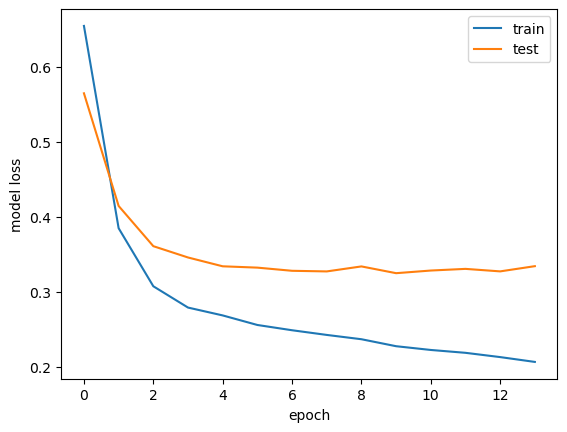

In [31]:
history=model.fit(train_ds, validation_data=val_ds, epochs=20, verbose=1,
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)]
                  )
model.save_weights('./saved_weights.h5')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('train_history.png')
plt.show()

## Finetuning

In [32]:
tf_validation_dataset

NameError: name 'tf_validation_dataset' is not defined

In [ ]:
from transformers.keras_callbacks import KerasMetricCallback
from datasets import evaluate

metric = load_metric("accuracy")


def compute_metrics(eval_predictions):
    predictions, labels = eval_predictions
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)


metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics, eval_dataset=tf_validation_dataset,
)